# Libs

In [127]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
import lib
import itertools
import collections
%load_ext autoreload
%autoreload 2
opt = adam()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [18]:
corpus = pd.read_csv("Corpus_new_coding/423_verbs_with_classes.csv",index_col="Unnamed: 0")

In [116]:
corpus.groupby('class').count().iloc[:,0]

class
class__ansiar       9
class__botar       30
class__cobrir       7
class__dizer        7
class__fazer       15
class__ler          5
class__mentir       8
class__none        20
class__pedir        7
class__por         27
class__regular    214
class__seguir      27
class__ter         10
class__testar      20
class__ver          6
class__vir         11
Name: v_inf, dtype: int64

In [153]:
corpus.groupby('class').count().apply(lambda g: (g / g.sum())*100).iloc[:,0]

class
class__ansiar      2.127660
class__botar       7.092199
class__cobrir      1.654846
class__dizer       1.654846
class__fazer       3.546099
class__ler         1.182033
class__mentir      1.891253
class__none        4.728132
class__pedir       1.654846
class__por         6.382979
class__regular    50.591017
class__seguir      6.382979
class__ter         2.364066
class__testar      4.728132
class__ver         1.418440
class__vir         2.600473
Name: v_inf, dtype: float64

In [19]:
proportions = corpus.groupby('class').count().apply(lambda g: round((g / g.sum())*100, 2)).iloc[:,0]

# Features

In [118]:
features = lib.features()

In [119]:
#http://www.ipachart.com/
with open('Files/phones.pickle', 'rb') as file:
    phones = pickle.load(file)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Training

In [136]:
model, decode_from_df, history = lib.train(corpus, epochs=300)

In [121]:
model_big, decode_from_df_big, history_big = lib.train(corpus, epochs=2000)

# F1 Plot, Precision, Recall Plot

## 300 Epochs

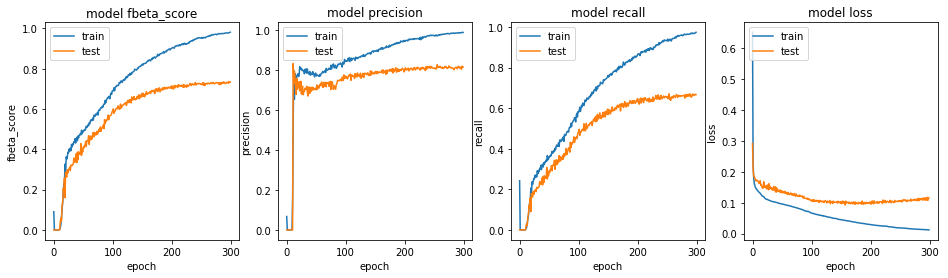

In [122]:
lib.plot_results(history)

In [123]:
history.history['val_fbeta_score'][-1]

0.7332813739776611

In [124]:
history.history['val_recall'][-1]

0.6664310693740845

In [125]:
history.history['val_precision'][-1]

0.8150389194488525

## 2000 Epochs

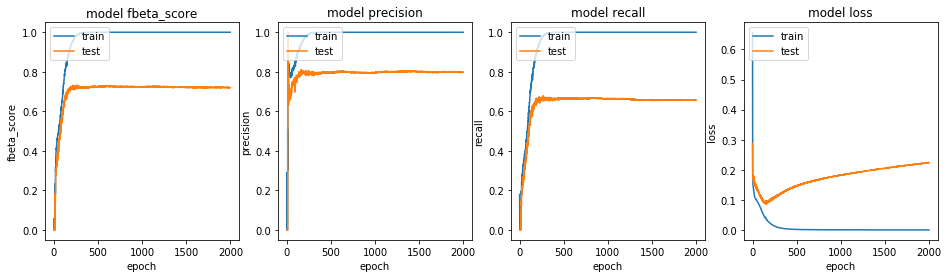

In [126]:
lib.plot_results(history_big)

# KFold Analysis

In [127]:
all_decodings = lib.kfold(corpus, n=5)

(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)


In [131]:
all_decodings = all_decodings.sort_values('class')

In [132]:
all_decodings.to_csv("Files/all_decodings.csv", index=None)

# Results 

In [38]:
all_decodings = pd.read_csv("Files/all_decodings.csv")

## Accuracy

In [39]:
all_decodings['correct'] = np.where((all_decodings['predicted'] == all_decodings['target']) , 1, 0)

Number of correct predictions 

In [40]:
all_decodings.correct.sum()

63

In [41]:
results = pd.concat([all_decodings.groupby('class').sum(), proportions], axis=1)

In [42]:
results.columns = ['correct', 'proportion_in_corpus']

In [43]:
total_per_class = all_decodings.groupby('class').count().infinitive

In [44]:
results['accuracy'] = results.correct.divide(total_per_class)

In [45]:
results['total'] = total_per_class

In [46]:
results = results[['correct', 'total','accuracy','proportion_in_corpus']]

In [49]:
results['accuracy'] = results.accuracy.apply(lambda x: round(x,2))

In [50]:
results.sort_values('proportion_in_corpus', ascending=False)

,correct,total,accuracy,proportion_in_corpus
class,,,,
class__regular,41,214,0.19,50.59
class__botar,4,30,0.13,7.09
class__por,0,27,0.00,6.38
class__seguir,9,27,0.33,6.38
class__none,0,20,0.00,4.73
class__testar,0,20,0.00,4.73
class__fazer,4,15,0.27,3.55
class__vir,0,11,0.00,2.60
class__ter,2,10,0.20,2.36


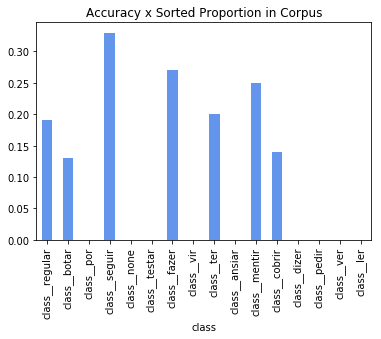

In [167]:
results.sort_values('proportion_in_corpus', ascending=False).accuracy.plot.bar(color='cornflowerblue', title='Accuracy x Sorted Proportion in Corpus')

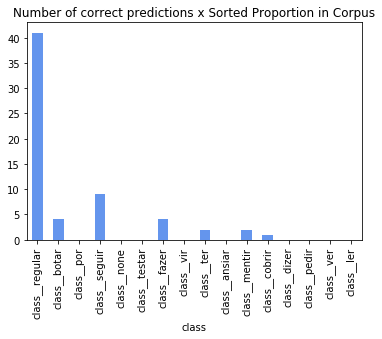

In [168]:
results.sort_values('proportion_in_corpus', ascending=False).correct.plot.bar(color='cornflowerblue', title='Number of correct predictions x Sorted Proportion in Corpus')

In [67]:
results.to_csv('Files/error_analysis.csv', index='class')

## Homogeneity among classes

In [154]:
results = pd.read_csv('Files/error_analysis.csv', index_col='class')

In [155]:
perplexity = corpus.groupby('class').v_conj.apply(lib.perplexity)

In [157]:
results['perplexity'] = perplexity
results

,correct,total,accuracy,proportion_in_corpus,perplexity
class,,,,,
class__ansiar,0,9,0.00,2.13,1.073437
class__botar,4,30,0.13,7.09,1.031179
class__cobrir,1,7,0.14,1.65,1.118949
class__dizer,0,7,0.00,1.65,1.094539
class__fazer,4,15,0.27,3.55,1.040148
class__ler,0,5,0.00,1.18,1.172332
class__mentir,2,8,0.25,1.89,1.089055
class__none,0,20,0.00,4.73,1.041227
class__pedir,0,7,0.00,1.65,1.115955


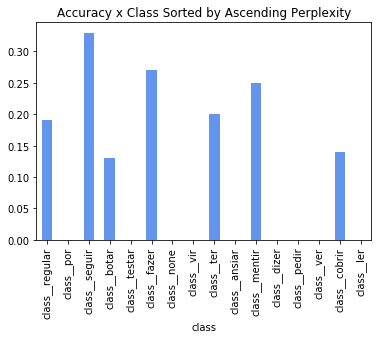

In [166]:
results.sort_values('perplexity', ascending=True).accuracy.plot.bar(color='cornflowerblue', title='Accuracy x Class Sorted by Ascending Perplexity')

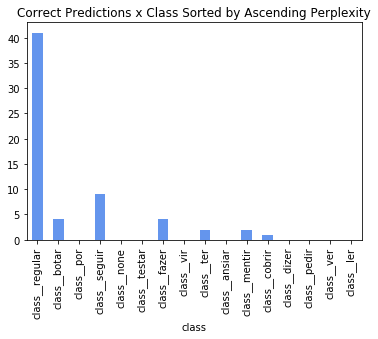

In [169]:
results.sort_values('proportion_in_corpus', ascending=False).correct.plot.bar(color='cornflowerblue', title='Correct Predictions x Class Sorted by Ascending Perplexity')

In [160]:
results.to_csv('Files/error_analysis.csv')

# Renorm 

In [138]:
all_decodings_renorm = lib.kfold(corpus, renorm=True, n=5)

(333, 3) (90, 3)
(335, 3) (88, 3)
(340, 3) (83, 3)
(341, 3) (82, 3)
(343, 3) (80, 3)


In [148]:
all_decodings_renorm['correct'] = np.where((all_decodings_renorm['predicted'] == all_decodings_renorm['target']) , 1, 0)

In [149]:
all_decodings_renorm.correct.sum()

30

In [150]:
all_decodings_renorm.groupby('class').sum()

,correct
class,
class__ansiar,0
class__botar,6
class__cobrir,0
class__dizer,0
class__fazer,0
class__ler,0
class__mentir,0
class__none,0
class__pedir,0


# Learning Curve x Train Size

In [30]:
lc = {}
for length in [100, 150, 250, 300, 393]:
    history = lib.train(length)
    lc[length] = history.history['val_fbeta_score'][-1], history.history['recall'][-1], history.history['precision'][-1]

CPU times: user 35min 18s, sys: 3min 47s, total: 39min 5s
Wall time: 11min 20s


In [31]:
lc

{100: (0.5534803867340088, 0.6876574158668518, 0.9181614518165588),
 150: (0.5637180805206299, 0.7294632792472839, 0.9192546606063843),
 250: (0.7961629629135132, 0.8921688175201417, 0.9658581089973449),
 300: (0.7927590012550354, 0.9350285490353902, 0.9777678648630778),
 393: (0.7852533459663391, 0.9763083427574983, 0.9875784125297692)}

with open('WickelfeaturesProject/Files/learning_curve.pickle', 'wb') as file:
    pickle.dump(lc, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('WickelfeaturesProject/Files/lc.pickle', 'rb') as file:
    lc = pickle.load(file)